In [1]:
# Transformations Performance Testing Setup and Tips

print("🎯 Transformations Performance Testing Tips:")
print("- Transformation performance depends on data volume, complexity, and CDF resources")
print("- Job execution time varies based on query complexity and data source size")
print("- Scheduling overhead is typically minimal but can accumulate with many jobs")
print("- Monitor resource utilization to identify bottlenecks")
print("- Consider data partitioning strategies for large datasets")
print("- Test both SQL and Spark transformations if available")

print("\n📊 Test Categories:")
print("- Transformation job creation and configuration")
print("- Job execution performance (various data sizes)")
print("- Scheduling and triggering mechanisms")
print("- Data pipeline throughput and latency")
print("- Resource monitoring and optimization")
print("- Error handling and retry performance")

print("\n📝 Next Steps:")
print("- Analyze execution patterns for your specific transformations")
print("- Compare different transformation types (SQL vs Spark)")
print("- Test with realistic data volumes and complexity")
print("- Monitor resource usage during peak loads")
print("- Plan for error handling and recovery strategies")

print("\n⚠️ Important Notes:")
print("- Transformation jobs may take time to complete")
print("- Be aware of CDF compute resources and limits")
print("- Test in a dedicated environment when possible")
print("- Some operations may incur costs based on usage")
print("- Clean up test transformations to avoid ongoing executions")


🎯 Transformations Performance Testing Tips:
- Transformation performance depends on data volume, complexity, and CDF resources
- Job execution time varies based on query complexity and data source size
- Scheduling overhead is typically minimal but can accumulate with many jobs
- Monitor resource utilization to identify bottlenecks
- Consider data partitioning strategies for large datasets
- Test both SQL and Spark transformations if available

📊 Test Categories:
- Transformation job creation and configuration
- Job execution performance (various data sizes)
- Scheduling and triggering mechanisms
- Data pipeline throughput and latency
- Resource monitoring and optimization
- Error handling and retry performance

📝 Next Steps:
- Analyze execution patterns for your specific transformations
- Compare different transformation types (SQL vs Spark)
- Test with realistic data volumes and complexity
- Monitor resource usage during peak loads
- Plan for error handling and recovery strategies

⚠

In [2]:
# Import required libraries
import sys
sys.path.append('../..')

from utilities.performance_utils import PerformanceTracker, benchmark_operation, generate_test_data
from configs.cdf_config import config
import pandas as pd
import numpy as np
import time
import json
import random
import string
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

try:
    from cognite.client import CogniteClient
    from cognite.client.data_classes import (
        Transformation, 
        TransformationJob,
        TransformationDestination,
        TransformationSchedule,
        Datapoint,
        Row
    )
    CDF_IMPORTS_AVAILABLE = True
    print("✅ Successfully imported CDF SDK classes")
    print("   Transformations API available for performance testing")
except ImportError as e:
    print(f"❌ CDF SDK imports not available: {e}")
    print("Please install cognite-sdk: pip install cognite-sdk --upgrade")
    CDF_IMPORTS_AVAILABLE = False

# For plotting (optional)
try:
    import matplotlib.pyplot as plt
    plt.style.use('default')
    PLOTTING_AVAILABLE = True
    print("✅ Matplotlib available for plotting")
except ImportError:
    print("⚠️  Matplotlib not available. Install with: pip install matplotlib")
    PLOTTING_AVAILABLE = False


✅ Successfully imported CDF SDK classes
   Transformations API available for performance testing
✅ Matplotlib available for plotting


In [3]:
# Initialize CDF client using the client setup utility
from utilities.client_setup import get_client, test_connection

# Get the configured CDF client
client = get_client()

# Transformations performance testing configuration
TEST_DATABASE = "transformation_perf_test"
TEST_TABLE_PREFIX = "perf_test_"
TEST_TRANSFORMATION_PREFIX = "perf_transform_"

if client is None:
    print("Failed to create CDF client. Please check your .env file.")
    print("Run: python ../../test_connection.py to test your connection")
else:
    # Test the connection
    if test_connection():
        print("Ready to run Transformations performance tests!")
        print(f"SDK version: {client.version if hasattr(client, 'version') else 'Available'}")
    else:
        print("Connection test failed. Please check your credentials.")


✓ Successfully connected to CDF project: templates-dev
🔍 Testing CDF connection...
📋 Current .env configuration:
----------------------------------------
  CDF_PROJECT: templates-dev
  CDF_CLUSTER: aws-dub-dev
  CDF_BASE_URL: https://aws-dub-dev.cognitedata.com
  DEFAULT_BATCH_SIZE: 1000
  DEFAULT_ITERATIONS: 10
  LOG_LEVEL: INFO
  CDF_CLIENT_ID: 8242****************************a218
  CDF_CLIENT_SECRET: KN98********************************fb.o
  CDF_TENANT_ID: b897****************************1a62
----------------------------------------
✓ Configuration is valid
✓ Successfully connected to CDF project: templates-dev
✓ Connection successful!
  Project: templates-dev


C:\Users\JanIngeBergseth\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py:766: UserWarning: You are using version='7.76.1' of the SDK, however version='7.77.1' is available. To suppress this warning, either upgrade or do the following:
>>> from cognite.client.config import global_config
>>> global_config.disable_pypi_version_check = True
  _threading_Thread_run(self)


  Token is valid and accessible
Ready to run Transformations performance tests!
SDK version: 7.76.1


In [4]:
# Verify client and imports are available before proceeding
if client is None:
    raise RuntimeError(
        "CDF client is not available. Cannot proceed with Transformations performance tests.\n"
        "Please ensure your .env file is properly configured."
    )

if not CDF_IMPORTS_AVAILABLE:
    raise RuntimeError(
        "CDF SDK imports are not available. Cannot proceed with Transformations tests.\n"
        "Please install cognite-sdk: pip install cognite-sdk --upgrade"
    )

print("🚀 Client verified. Initializing performance tracker...")

# Initialize performance tracker for transformation operations
tracker = PerformanceTracker("transformation_operations")

print("✅ Ready to run Transformations performance tests!")

# Helper functions for transformation testing
def generate_test_table_name():
    """Generate a unique test table name."""
    timestamp = int(time.time())
    return f"{TEST_TABLE_PREFIX}table_{timestamp}_{random.randint(1000, 9999)}"

def generate_test_transformation_name():
    """Generate a unique test transformation name."""
    timestamp = int(time.time())
    return f"{TEST_TRANSFORMATION_PREFIX}{timestamp}_{random.randint(1000, 9999)}"

def create_test_raw_data(table_name, row_count=100):
    """Create test data in a RAW table for transformation testing."""
    if client is None:
        return False
    
    try:
        # Ensure database exists
        try:
            client.raw.databases.create(TEST_DATABASE)
        except:
            pass  # Database might already exist
        
        # Create table
        try:
            client.raw.tables.create(TEST_DATABASE, table_name)
        except:
            pass  # Table might already exist
        
        # Generate test rows
        rows = []
        for i in range(row_count):
            row = Row(
                key=f"test_key_{i}_{int(time.time())}",
                columns={
                    "id": i,
                    "value": random.uniform(0, 1000),
                    "category": random.choice(["A", "B", "C", "D"]),
                    "timestamp": (datetime.now() - timedelta(days=random.randint(0, 30))).isoformat(),
                    "status": random.choice(["active", "inactive", "pending"]),
                    "score": random.randint(1, 100)
                }
            )
            rows.append(row)
        
        # Insert rows
        client.raw.rows.insert(TEST_DATABASE, table_name, rows)
        return True
        
    except Exception as e:
        print(f"Error creating test data: {e}")
        return False

def create_simple_sql_transformation(name, source_table, dest_table=None):
    """Create a simple SQL transformation for testing."""
    if dest_table is None:
        dest_table = f"result_{source_table}"
    
    sql_query = f"""
    SELECT 
        cast(`id` as INT) as id,
        cast(`value` as DOUBLE) as value,
        `category`,
        `timestamp`,
        `status`,
        cast(`score` as INT) as score,
        CASE 
            WHEN cast(`score` as INT) >= 80 THEN 'high'
            WHEN cast(`score` as INT) >= 50 THEN 'medium'
            ELSE 'low'
        END as score_category
    FROM `{TEST_DATABASE}`.`{source_table}`
    WHERE `status` = 'active'
    ORDER BY cast(`value` as DOUBLE) DESC
    """
    
    # Import credentials for transformations
    try:
        from cognite.client.data_classes import OidcCredentials
        from configs.cdf_config import config
        
        # Debug: Print config values to ensure they're accessible
        print(f"    Debug - Config client_id: {config.client_id[:8]}****")
        print(f"    Debug - Config project: {config.project}")
        print(f"    Debug - Config base_url: {config.base_url}")
        
        # Create OIDC credentials using your current configuration
        credentials = OidcCredentials(
            client_id=config.client_id,
            client_secret=config.client_secret,
            scopes=[f"{config.base_url}/.default"],
            token_uri=f"https://login.microsoftonline.com/{config.tenant_id}/oauth2/v2.0/token",
            cdf_project_name=config.project
        )
        
        print(f"    Debug - Successfully created OIDC credentials")
        
    except Exception as e:
        print(f"    ❌ Error creating OIDC credentials: {e}")
        print(f"    Falling back to None credentials (this will likely fail)")
        credentials = None
    
    transformation = Transformation(
        name=name,
        external_id=name,
        query=sql_query,
        destination=TransformationDestination.raw(
            database=TEST_DATABASE,
            table=dest_table
        ),
        ignore_null_fields=True,  # REQUIRED: Handle null values
        is_public=False,
        # Provide proper OIDC credentials for RAW access
        source_oidc_credentials=credentials,  # Use configured credentials for source
        destination_oidc_credentials=credentials  # Use configured credentials for destination
    )
    
    return transformation

def wait_for_transformation_completion(job_id, timeout_seconds=300):
    """Wait for a transformation job to complete."""
    if client is None:
        return None
    
    start_time = time.time()
    
    while time.time() - start_time < timeout_seconds:
        try:
            job = client.transformations.jobs.retrieve(job_id)
            if job and job.status in ["Completed", "Failed"]:
                return job
            time.sleep(2)  # Check every 2 seconds
        except Exception as e:
            print(f"Error checking job status: {e}")
            break
    
    return None  # Timeout

def cleanup_test_transformations():
    """Clean up test transformations."""
    if client is None:
        return False
    
    try:
        # List all transformations
        transformations = client.transformations.list()
        
        # Delete test transformations
        for transformation in transformations:
            if transformation.name and transformation.name.startswith(TEST_TRANSFORMATION_PREFIX):
                try:
                    client.transformations.delete(id=transformation.id)
                    print(f"    Deleted transformation: {transformation.name}")
                except Exception as e:
                    print(f"    Warning: Could not delete transformation {transformation.name}: {e}")
        
        return True
    except Exception as e:
        print(f"Error cleaning up transformations: {e}")
        return False

print("🎯 Transformation test helpers ready!")
print("📁 Available helper functions:")
print("  - generate_test_table_name()")
print("  - generate_test_transformation_name()")
print("  - create_test_raw_data(table_name, row_count)")
print("  - create_simple_sql_transformation(name, source_table, dest_table)")
print("  - wait_for_transformation_completion(job_id, timeout_seconds)")
print("  - cleanup_test_transformations()")
print(f"📊 Test database: {TEST_DATABASE}")
print(f"📋 Test prefixes: {TEST_TABLE_PREFIX}, {TEST_TRANSFORMATION_PREFIX}")


🚀 Client verified. Initializing performance tracker...
✅ Ready to run Transformations performance tests!
🎯 Transformation test helpers ready!
📁 Available helper functions:
  - generate_test_table_name()
  - generate_test_transformation_name()
  - create_test_raw_data(table_name, row_count)
  - create_simple_sql_transformation(name, source_table, dest_table)
  - wait_for_transformation_completion(job_id, timeout_seconds)
  - cleanup_test_transformations()
📊 Test database: transformation_perf_test
📋 Test prefixes: perf_test_, perf_transform_


In [5]:
# Test 1: Transformation Job Creation and Execution Performance
def test_transformation_job_execution():
    """Test performance of creating and executing transformation jobs."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("🏗️ Testing transformation job execution performance...")
    
    results = {}
    created_transformations = []
    created_tables = []
    
    # Test with different data sizes
    test_sizes = [100, 500, 1000]  # Number of rows in source data
    
    for data_size in test_sizes:
        print(f"  Testing with {data_size} rows of source data...")
        
        try:
            # Create test data
            source_table = generate_test_table_name()
            created_tables.append(source_table)
            
            data_creation_success = create_test_raw_data(source_table, data_size)
            if not data_creation_success:
                print(f"    ❌ Failed to create test data for {data_size} rows")
                continue
            
            print(f"    Created source table '{source_table}' with {data_size} rows")
            
            # Test 1: Transformation creation
            def create_transformation():
                if client is None:
                    raise RuntimeError("Client not initialized")
                
                transformation_name = generate_test_transformation_name()
                print(f"    Creating transformation '{transformation_name}'")
                transformation = create_simple_sql_transformation(
                    transformation_name, 
                    source_table,
                    f"result_{source_table}"
                )
                
                created_transformation = client.transformations.create(transformation)
                created_transformations.append(created_transformation.id)
                return created_transformation
            
            # Benchmark transformation creation
            creation_results = benchmark_operation(create_transformation, iterations=3, warmup=1)
            results[f"creation_{data_size}_rows"] = creation_results
            print(f"    Mean creation time: {creation_results['mean_time']:.4f}s")
            
            # Test 2: Job execution
            if creation_results.get('return_value'):
                transformation = creation_results['return_value']
                
                def execute_transformation():
                    if client is None:
                        raise RuntimeError("Client not initialized")
                    
                    # Run the transformation
                    transformation_id = getattr(transformation, 'id', None)
                    if not transformation_id:
                        raise RuntimeError("Transformation has no valid ID")
                    
                    job = client.transformations.run(transformation_id)
                    job_id = getattr(job, 'id', None)
                    
                    if not job_id:
                        raise RuntimeError("Failed to start transformation job")
                    
                    # Wait for completion
                    completed_job = wait_for_transformation_completion(job_id, timeout_seconds=180)
                    
                    if completed_job:
                        return {
                            "job_id": job_id,
                            "status": getattr(completed_job, 'status', 'unknown'),
                            "success": True
                        }
                    else:
                        return {"job_id": job_id, "status": "timeout", "success": False}
                
                try:
                    # Benchmark job execution (fewer iterations due to longer execution time)
                    execution_results = benchmark_operation(execute_transformation, iterations=2, warmup=0)
                    results[f"execution_{data_size}_rows"] = execution_results
                    
                    print(f"    Mean job execution time: {execution_results['mean_time']:.2f}s")
                    
                    # Print additional execution details
                    if execution_results and isinstance(execution_results, dict):
                        return_value = execution_results.get('return_value')
                        if return_value and isinstance(return_value, dict):
                            print(f"    Job status: {return_value.get('status', 'unknown')}")
                            print(f"    Job success: {return_value.get('success', False)}")
                except Exception as e:
                    print(f"    ❌ Error in job execution benchmark: {e}")
                    results[f"execution_{data_size}_rows"] = None
            
        except Exception as e:
            print(f"    ❌ Error testing {data_size} rows: {e}")
            results[f"error_{data_size}_rows"] = str(e)
    
    # Store metadata for cleanup
    results['_metadata'] = {
        'created_transformations': created_transformations,
        'created_tables': created_tables
    }
    
    return results

# Run transformation job execution test
job_execution_results = test_transformation_job_execution()


🏗️ Testing transformation job execution performance...
  Testing with 100 rows of source data...
    Created source table 'perf_test_table_1753450606_3224' with 100 rows
    Creating transformation 'perf_transform_1753450606_6333'
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Creating transformation 'perf_transform_1753450607_3918'
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Creating transformation 'perf_transform_1753450609_3520'
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Creating transformation 'perf_transform_175

In [6]:
# Test 2: Transformation Scheduling Performance
def test_transformation_scheduling():
    """Test performance of transformation scheduling operations."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("⏰ Testing transformation scheduling performance...")
    
    results = {}
    created_transformations = []
    created_tables = []
    
    try:
        # Create test data for scheduling tests
        source_table = generate_test_table_name()
        created_tables.append(source_table)
        
        if not create_test_raw_data(source_table, 200):
            print("    ❌ Failed to create test data for scheduling tests")
            return None
        
        print(f"    Created source table '{source_table}' for scheduling tests")
        
        # Test 1: Schedule creation performance
        print("  Testing schedule creation...")
        
        def create_scheduled_transformation():
            if client is None:
                raise RuntimeError("Client not initialized")
            
            transformation_name = generate_test_transformation_name()
            transformation = create_simple_sql_transformation(
                transformation_name, 
                source_table,
                f"scheduled_result_{source_table}"
            )
            
            # Add a simple schedule (every hour)
            transformation.schedule = TransformationSchedule(
                interval="*/60 * * * *",  # Every hour
                is_paused=True  # Start paused for testing
            )
            
            created_transformation = client.transformations.create(transformation)
            created_transformations.append(created_transformation.id)
            return created_transformation
        
        try:
            benchmark_results = benchmark_operation(create_scheduled_transformation, iterations=3, warmup=1)
            results["schedule_creation"] = benchmark_results
            print(f"    Mean schedule creation time: {benchmark_results['mean_time']:.4f}s")
        except Exception as e:
            print(f"    ❌ Error in schedule creation: {e}")
            results["schedule_creation"] = None
        
        # Test 2: Schedule update performance
        print("  Testing schedule updates...")
        
        if created_transformations:
            def update_transformation_schedule():
                if client is None:
                    raise RuntimeError("Client not initialized")
                
                transformation_id = created_transformations[0]
                
                # Update the schedule
                print(f"    Updating transformation '{transformation_id}'")
                transformation = client.transformations.retrieve(transformation_id)
                transformation.schedule = TransformationSchedule(
                    interval="*/30 * * * *",  # Every 30 minutes
                    is_paused=True
                )
                updated_transformation = client.transformations.update(transformation)
                return updated_transformation
            
            try:
                benchmark_results = benchmark_operation(update_transformation_schedule, iterations=5, warmup=1)
                results["schedule_update"] = benchmark_results
                print(f"    Mean schedule update time: {benchmark_results['mean_time']:.4f}s")
            except Exception as e:
                print(f"    ❌ Error in schedule update: {e}")
                results["schedule_update"] = None
        
        # Test 3: Transformation listing with filters
        print("  Testing transformation listing...")
        
        def list_scheduled_transformations():
            if client is None:
                raise RuntimeError("Client not initialized")
            
            # List transformations with schedule filter
            transformations = client.transformations.list()
            
            # Filter for scheduled transformations
            scheduled_count = 0
            for t in transformations:
                if hasattr(t, 'schedule') and t.schedule is not None:
                    scheduled_count += 1
            
            return scheduled_count
        
        try:
            benchmark_results = benchmark_operation(list_scheduled_transformations, iterations=10, warmup=2)
            results["list_scheduled"] = benchmark_results
            print(f"    Mean listing time: {benchmark_results['mean_time']:.4f}s")
            
            if benchmark_results.get('return_value') is not None:
                print(f"    Scheduled transformations found: {benchmark_results['return_value']}")
        except Exception as e:
            print(f"    ❌ Error in transformation listing: {e}")
            results["list_scheduled"] = None
        
        # Test 4: Schedule pause/unpause performance
        print("  Testing schedule pause/unpause...")
        
        if created_transformations:
            def toggle_schedule_state():
                if client is None:
                    raise RuntimeError("Client not initialized")
                
                transformation_id = created_transformations[0]
                transformation = client.transformations.retrieve(transformation_id)

                # Pause schedule
                transformation.schedule = TransformationSchedule(
                    interval="*/30 * * * *",
                    is_paused=True
                )
                client.transformations.update(transformation)
                
                # Unpause schedule  
                transformation.schedule = TransformationSchedule(
                    interval="*/30 * * * *",
                    is_paused=False
                )
                client.transformations.update(transformation)

                # Pause again for safety
                transformation.schedule = TransformationSchedule(
                    interval="*/30 * * * *",
                    is_paused=True
                )
                client.transformations.update(transformation)
                
                return True
            
            try:
                benchmark_results = benchmark_operation(toggle_schedule_state, iterations=3, warmup=1)
                results["schedule_toggle"] = benchmark_results
                print(f"    Mean toggle time: {benchmark_results['mean_time']:.4f}s")
            except Exception as e:
                print(f"    ❌ Error in schedule toggle: {e}")
                results["schedule_toggle"] = None
    
    except Exception as e:
        print(f"    ❌ Error in scheduling tests: {e}")
        results["error"] = str(e)
    
    # Store metadata for cleanup
    results['_metadata'] = {
        'created_transformations': created_transformations,
        'created_tables': created_tables
    }
    
    return results

# Run transformation scheduling test
scheduling_results = test_transformation_scheduling()


⏰ Testing transformation scheduling performance...
    Created source table 'perf_test_table_1753450618_7477' for scheduling tests
  Testing schedule creation...
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Mean schedule creation time: 0.854

In [7]:
# Test 3: Data Pipeline Performance 
def test_data_pipeline_performance():
    """Test performance of data processing through transformation pipelines."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("🔄 Testing data pipeline performance...")
    
    results = {}
    created_transformations = []
    created_tables = []
    
    # Test different pipeline complexities
    pipeline_configs = [
        {"name": "simple", "row_count": 500, "complexity": "low"},
        {"name": "medium", "row_count": 1000, "complexity": "medium"},
        {"name": "complex", "row_count": 2000, "complexity": "high"}
    ]
    
    for config in pipeline_configs:
        print(f"  Testing {config['name']} pipeline ({config['row_count']} rows, {config['complexity']} complexity)...")
        
        try:
            # Create source data
            source_table = generate_test_table_name()
            created_tables.append(source_table)
            
            if not create_test_raw_data(source_table, config['row_count']):
                print(f"    ❌ Failed to create test data for {config['name']} pipeline")
                continue
            
            # Create different SQL transformations based on complexity
            if config['complexity'] == 'low':
                sql_query = f"""
                SELECT 
                    cast(`id` as INT) as id,
                    cast(`value` as DOUBLE) as value,
                    `category`,
                    `status`
                FROM `{TEST_DATABASE}`.`{source_table}`
                WHERE `status` = 'active'
                """
            elif config['complexity'] == 'medium':
                sql_query = f"""
                SELECT 
                    cast(`id` as INT) as id,
                    cast(`value` as DOUBLE) as value,
                    `category`,
                    `status`,
                    cast(`score` as INT) as score,
                    CASE 
                        WHEN cast(`score` as INT) >= 80 THEN 'high'
                        WHEN cast(`score` as INT) >= 50 THEN 'medium'
                        ELSE 'low'
                    END as score_category,
                    cast(`value` as DOUBLE) * cast(`score` as INT) as weighted_value
                FROM `{TEST_DATABASE}`.`{source_table}`
                WHERE `status` IN ('active', 'pending')
                ORDER BY cast(`value` as DOUBLE) DESC
                """
            else:  # high complexity
                sql_query = f"""
                SELECT 
                    cast(`id` as INT) as id,
                    cast(`value` as DOUBLE) as value,
                    `category`,
                    `status`,
                    cast(`score` as INT) as score,
                    CASE 
                        WHEN cast(`score` as INT) >= 80 THEN 'high'
                        WHEN cast(`score` as INT) >= 50 THEN 'medium'
                        ELSE 'low'
                    END as score_category,
                    cast(`value` as DOUBLE) * cast(`score` as INT) as weighted_value,
                    ROW_NUMBER() OVER (PARTITION BY `category` ORDER BY cast(`value` as DOUBLE) DESC) as category_rank,
                    AVG(cast(`value` as DOUBLE)) OVER (PARTITION BY `category`) as category_avg_value,
                    COUNT(*) OVER (PARTITION BY `status`) as status_count
                FROM `{TEST_DATABASE}`.`{source_table}`
                WHERE `status` IN ('active', 'pending')
                  AND cast(`value` as DOUBLE) > 100
                ORDER BY cast(`value` as DOUBLE) DESC, `category`
                """
            
            def create_and_run_pipeline():
                if client is None:
                    raise RuntimeError("Client not initialized")
                
                transformation_name = generate_test_transformation_name()
                dest_table = f"pipeline_result_{source_table}"
                
                # Import credentials for transformations
                try:
                    from cognite.client.data_classes import OidcCredentials
                    from configs.cdf_config import config
                    
                    # Debug: Print config values to ensure they're accessible
                    print(f"    Debug - Pipeline config client_id: {config.client_id[:8]}****")
                    print(f"    Debug - Pipeline config project: {config.project}")
                    
                    # Create OIDC credentials using your current configuration
                    credentials = OidcCredentials(
                        client_id=config.client_id,
                        client_secret=config.client_secret,
                        scopes=[f"{config.base_url}/.default"],
                        token_uri=f"https://login.microsoftonline.com/{config.tenant_id}/oauth2/v2.0/token",
                        cdf_project_name=config.project
                    )
                    
                    print(f"    Debug - Successfully created pipeline OIDC credentials")
                    
                except Exception as e:
                    print(f"    ❌ Error creating pipeline OIDC credentials: {e}")
                    print(f"    Falling back to None credentials (this will likely fail)")
                    credentials = None
                
                transformation = Transformation(
                    name=transformation_name,
                    external_id=transformation_name,
                    query=sql_query,
                    destination=TransformationDestination.raw(
                        database=TEST_DATABASE,
                        table=dest_table
                    ),
                    ignore_null_fields=True,  # REQUIRED: Handle null values
                    is_public=False,  # Use private transformation
                    # Provide proper OIDC credentials for RAW access
                    source_oidc_credentials=credentials,  # Use configured credentials for source
                    destination_oidc_credentials=credentials  # Use configured credentials for destination
                )
                
                # Create transformation
                created_transformation = client.transformations.create(transformation)
                created_transformations.append(created_transformation.id)
                
                # Run transformation
                job = client.transformations.run(created_transformation.id)
                
                # Wait for completion (with shorter timeout for performance testing)
                completed_job = wait_for_transformation_completion(
                    getattr(job, 'id', None), 
                    timeout_seconds=120
                )
                
                if completed_job:
                    return {
                        "transformation_id": created_transformation.id,
                        "job_id": getattr(job, 'id', None),
                        "status": getattr(completed_job, 'status', 'unknown'),
                        "success": getattr(completed_job, 'status', '') == 'Completed'
                    }
                else:
                    return {
                        "transformation_id": created_transformation.id,
                        "job_id": getattr(job, 'id', None),
                        "status": "timeout",
                        "success": False
                    }
            
            # Benchmark pipeline execution
            try:
                benchmark_results = benchmark_operation(create_and_run_pipeline, iterations=2, warmup=0)
                results[f"pipeline_{config['name']}"] = benchmark_results
                
                print(f"    Mean pipeline time: {benchmark_results['mean_time']:.2f}s")
                
                # Print pipeline results
                if benchmark_results.get('return_value'):
                    pipeline_result = benchmark_results['return_value']
                    if isinstance(pipeline_result, dict):
                        print(f"    Pipeline status: {pipeline_result.get('status', 'unknown')}")
                        print(f"    Pipeline success: {pipeline_result.get('success', False)}")
                        
            except Exception as e:
                print(f"    ❌ Error in {config['name']} pipeline: {e}")
                results[f"pipeline_{config['name']}"] = None
                
        except Exception as e:
            print(f"    ❌ Error setting up {config['name']} pipeline: {e}")
            results[f"pipeline_{config['name']}_setup"] = str(e)
    
    # Store metadata for cleanup
    results['_metadata'] = {
        'created_transformations': created_transformations,
        'created_tables': created_tables
    }
    
    return results

# Run data pipeline performance test
pipeline_results = test_data_pipeline_performance()


🔄 Testing data pipeline performance...
  Testing simple pipeline (500 rows, low complexity)...
    Debug - Pipeline config client_id: 8242bbc3****
    Debug - Pipeline config project: templates-dev
    Debug - Successfully created pipeline OIDC credentials
    Debug - Pipeline config client_id: 8242bbc3****
    Debug - Pipeline config project: templates-dev
    Debug - Successfully created pipeline OIDC credentials
    Mean pipeline time: 2.29s
  Testing medium pipeline (1000 rows, medium complexity)...
    Debug - Pipeline config client_id: 8242bbc3****
    Debug - Pipeline config project: templates-dev
    Debug - Successfully created pipeline OIDC credentials
    Debug - Pipeline config client_id: 8242bbc3****
    Debug - Pipeline config project: templates-dev
    Debug - Successfully created pipeline OIDC credentials
    Mean pipeline time: 2.37s
  Testing complex pipeline (2000 rows, high complexity)...
    Debug - Pipeline config client_id: 8242bbc3****
    Debug - Pipeline confi

In [8]:
# Test 4: Transformation Monitoring Performance
def test_transformation_monitoring():
    """Test performance of transformation monitoring and job tracking operations."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("📊 Testing transformation monitoring performance...")
    
    results = {}
    created_transformations = []
    created_tables = []
    job_ids = []
    
    try:
        # Clean up any old transformations first to ensure fresh start with credentials
        print("  Cleaning up any existing test transformations...")
        cleanup_test_transformations()
        
        # Create test setup for monitoring
        source_table = generate_test_table_name()
        created_tables.append(source_table)
        
        if not create_test_raw_data(source_table, 300):
            print("    ❌ Failed to create test data for monitoring tests")
            return None
        
        print(f"    Created source table '{source_table}' for monitoring tests")
        
        # Create a few transformations to monitor
        for i in range(3):
            transformation_name = generate_test_transformation_name()
            transformation = create_simple_sql_transformation(
                transformation_name,
                source_table,
                f"monitor_result_{i}_{source_table}"
            )
            
            created_transformation = client.transformations.create(transformation)
            created_transformations.append(created_transformation.id)
        
        print(f"    Created {len(created_transformations)} transformations for monitoring")
        
        # Test 1: Job listing performance
        print("  Testing job listing performance...")
        
        def list_transformation_jobs():
            if client is None:
                raise RuntimeError("Client not initialized")
            
            # List jobs for all transformations
            total_jobs = 0
            for transformation_id in created_transformations:
                try:
                    jobs = client.transformations.jobs.list(transformation_id=transformation_id)
                    total_jobs += len(jobs)
                except Exception:
                    pass  # Some transformations might not have jobs yet
            
            return total_jobs
        
        try:
            benchmark_results = benchmark_operation(list_transformation_jobs, iterations=10, warmup=2)
            results["job_listing"] = benchmark_results
            print(f"    Mean job listing time: {benchmark_results['mean_time']:.4f}s")
            
            if benchmark_results.get('return_value') is not None:
                print(f"    Total jobs found: {benchmark_results['return_value']}")
        except Exception as e:
            print(f"    ❌ Error in job listing: {e}")
            results["job_listing"] = None
        
        # Test 2: Run jobs for monitoring
        print("  Running jobs for monitoring tests...")
        
        for transformation_id in created_transformations[:2]:  # Run 2 jobs
            try:
                job = client.transformations.run(transformation_id)
                if job and hasattr(job, 'id'):
                    job_ids.append(job.id)
                    print(f"    Started job: {job.id}")
            except Exception as e:
                print(f"    Warning: Could not start job for transformation {transformation_id}: {e}")
        
        # Test 3: Job status checking performance
        print("  Testing job status checking...")
        
        def check_job_statuses():
            if client is None:
                raise RuntimeError("Client not initialized")
            
            status_counts = {"running": 0, "completed": 0, "failed": 0, "other": 0}
            
            for job_id in job_ids:
                try:
                    job = client.transformations.jobs.retrieve(job_id)
                    if job and hasattr(job, 'status') and job.status:
                        status = job.status.lower()
                        if status in status_counts:
                            status_counts[status] += 1
                        else:
                            status_counts["other"] += 1
                    else:
                        status_counts["other"] += 1
                except Exception:
                    status_counts["other"] += 1
            
            return status_counts
        
        try:
            benchmark_results = benchmark_operation(check_job_statuses, iterations=15, warmup=3)
            results["status_checking"] = benchmark_results
            print(f"    Mean status check time: {benchmark_results['mean_time']:.4f}s")
            
            if benchmark_results.get('return_value'):
                status_summary = benchmark_results['return_value']
                if isinstance(status_summary, dict):
                    print(f"    Status summary: {status_summary}")
        except Exception as e:
            print(f"    ❌ Error in status checking: {e}")
            results["status_checking"] = None
        
        # Test 4: Transformation metrics retrieval
        print("  Testing transformation metrics retrieval...")
        
        def get_transformation_metrics():
            if client is None:
                raise RuntimeError("Client not initialized")
            
            metrics = {}
            for transformation_id in created_transformations:
                try:
                    # Get transformation details
                    transformation = client.transformations.retrieve(transformation_id)
                    
                    if transformation:
                        metrics[transformation_id] = {
                            "name": getattr(transformation, 'name', 'unknown'),
                            "created_time": getattr(transformation, 'created_time', None),
                            "last_updated": getattr(transformation, 'last_updated_time', None)
                        }
                except Exception:
                    metrics[transformation_id] = {"error": True}
            
            return len(metrics)
        
        try:
            benchmark_results = benchmark_operation(get_transformation_metrics, iterations=8, warmup=2)
            results["metrics_retrieval"] = benchmark_results
            print(f"    Mean metrics retrieval time: {benchmark_results['mean_time']:.4f}s")
            
            if benchmark_results.get('return_value') is not None:
                print(f"    Transformations processed: {benchmark_results['return_value']}")
        except Exception as e:
            print(f"    ❌ Error in metrics retrieval: {e}")
            results["metrics_retrieval"] = None
        
        # Test 5: Bulk operations monitoring
        print("  Testing bulk operations monitoring...")
        
        def monitor_bulk_operations():
            if client is None:
                raise RuntimeError("Client not initialized")
            
            # List all transformations
            all_transformations = client.transformations.list()
            transformation_count = len(all_transformations)
            
            # List all jobs across transformations
            all_jobs_count = 0
            for transformation in all_transformations[:10]:  # Limit to first 10 for performance
                try:
                    if hasattr(transformation, 'id'):
                        jobs = client.transformations.jobs.list(transformation_id=transformation.id)
                        all_jobs_count += len(jobs)
                except Exception:
                    pass
            
            return {"transformations": transformation_count, "jobs_checked": all_jobs_count}
        
        try:
            benchmark_results = benchmark_operation(monitor_bulk_operations, iterations=3, warmup=1)
            results["bulk_monitoring"] = benchmark_results
            print(f"    Mean bulk monitoring time: {benchmark_results['mean_time']:.4f}s")
            
            if benchmark_results.get('return_value'):
                bulk_result = benchmark_results['return_value']
                if isinstance(bulk_result, dict):
                    print(f"    Transformations: {bulk_result.get('transformations', 0)}")
                    print(f"    Jobs checked: {bulk_result.get('jobs_checked', 0)}")
        except Exception as e:
            print(f"    ❌ Error in bulk monitoring: {e}")
            results["bulk_monitoring"] = None
    
    except Exception as e:
        print(f"    ❌ Error in monitoring tests setup: {e}")
        results["setup_error"] = str(e)
    
    # Store metadata for cleanup
    results['_metadata'] = {
        'created_transformations': created_transformations,
        'created_tables': created_tables,
        'job_ids': job_ids
    }
    
    return results

# Run transformation monitoring test
monitoring_results = test_transformation_monitoring()

📊 Testing transformation monitoring performance...
  Cleaning up any existing test transformations...
    Created source table 'perf_test_table_1753450641_6995' for monitoring tests
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Debug - Config client_id: 8242bbc3****
    Debug - Config project: templates-dev
    Debug - Config base_url: https://aws-dub-dev.cognitedata.com
    Debug - Successfully created OIDC credentials
    Created 3 transformations for monitoring
  Testing job listing performance...
    Mean job listing time: 0.1862s
  Running jobs for monitoring tests...
    Started job: 239432
    Started job: 239433
  Testing job 

📈 Transformations Performance Test Results Summary

🏗️ Job Execution Performance:
  creation_100_rows         | 0.9330s avg | 1.07 ops/s
  creation_500_rows         | 0.8746s avg | 1.14 ops/s
  creation_1000_rows        | 0.7378s avg | 1.36 ops/s

⏰ Scheduling Performance:
  schedule_creation         | 0.8544s avg | 1.17 ops/s
  schedule_update           | 0.1414s avg | 7.07 ops/s
  list_scheduled            | 0.0730s avg | 13.70 ops/s
  schedule_toggle           | 0.2946s avg | 3.39 ops/s

🔄 Pipeline Performance:
  pipeline_simple           | 2.2851s avg | 0.44 ops/s
  pipeline_medium           | 2.3684s avg | 0.42 ops/s
  pipeline_complex          | 2.3406s avg | 0.43 ops/s

📊 Monitoring Performance:
  job_listing               | 0.1862s avg | 5.37 ops/s
  status_checking           | 0.1389s avg | 7.20 ops/s
  metrics_retrieval         | 0.1950s avg | 5.13 ops/s
  bulk_monitoring           | 0.7246s avg | 1.38 ops/s


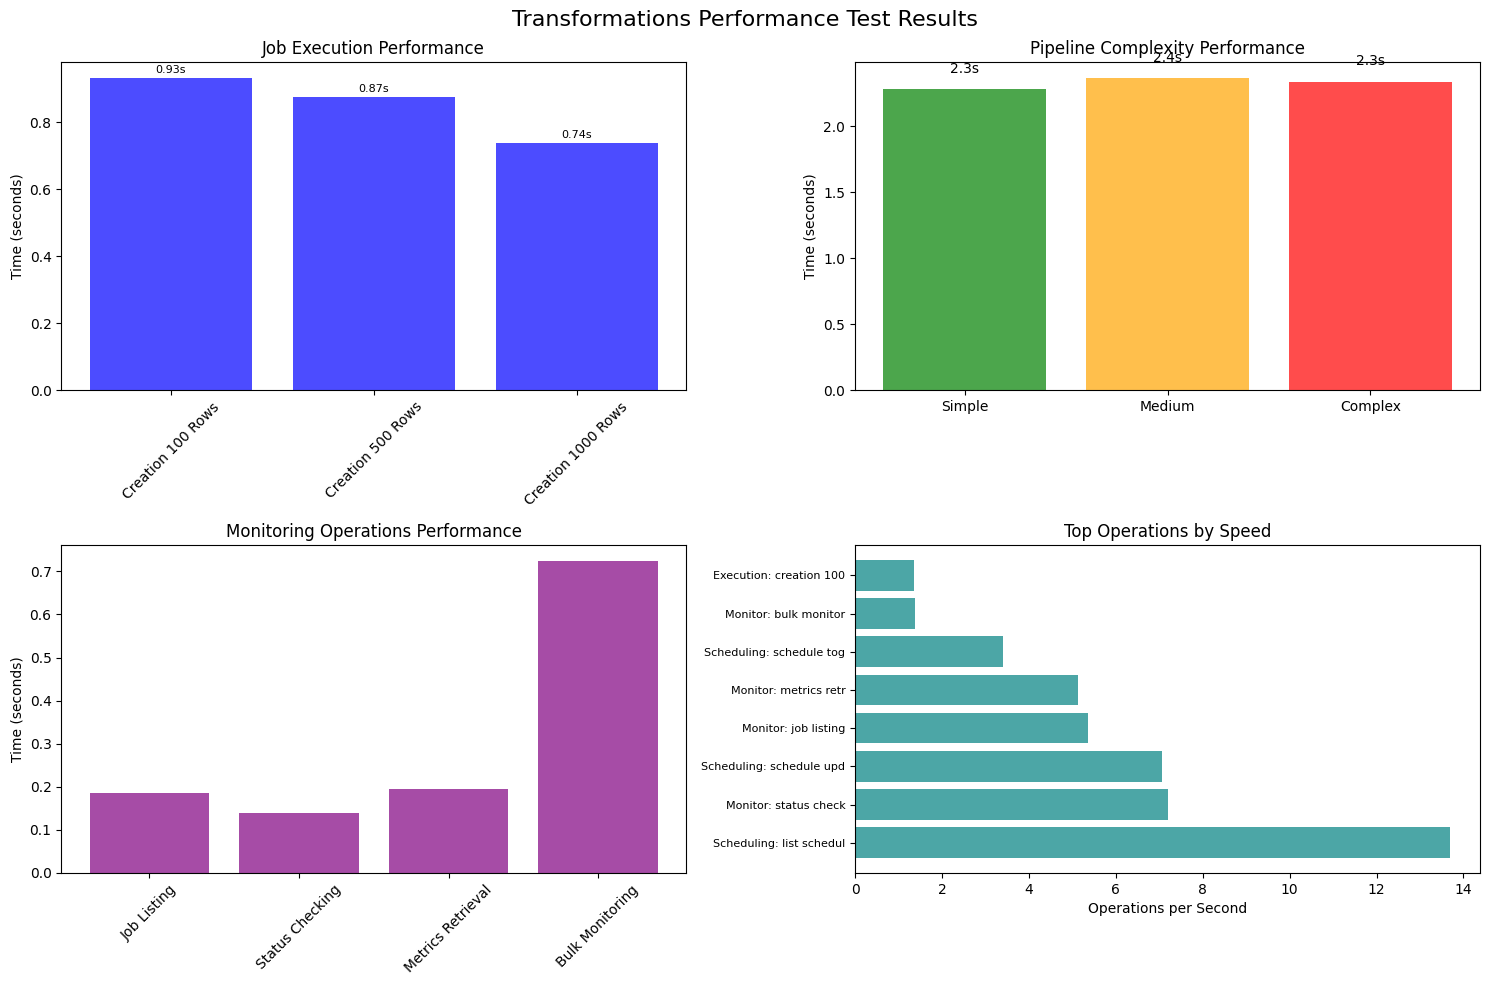


✅ Transformations performance testing complete!
💾 Results can be saved using the PerformanceTracker.save_results() method


In [9]:
# Performance Results Summary and Visualization
def summarize_and_visualize_transformation_results():
    """Summarize all transformation performance test results and create visualizations."""
    
    print("📈 Transformations Performance Test Results Summary")
    print("=" * 60)
    
    # Summarize each test category
    if 'job_execution_results' in globals() and job_execution_results:
        print("\n🏗️ Job Execution Performance:")
        for test_name, results in job_execution_results.items():
            if results and isinstance(results, dict) and 'mean_time' in results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'scheduling_results' in globals() and scheduling_results:
        print("\n⏰ Scheduling Performance:")
        for test_name, results in scheduling_results.items():
            if results and isinstance(results, dict) and 'mean_time' in results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'pipeline_results' in globals() and pipeline_results:
        print("\n🔄 Pipeline Performance:")
        for test_name, results in pipeline_results.items():
            if results and isinstance(results, dict) and 'mean_time' in results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'monitoring_results' in globals() and monitoring_results:
        print("\n📊 Monitoring Performance:")
        for test_name, results in monitoring_results.items():
            if results and isinstance(results, dict) and 'mean_time' in results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    # Create visualization if matplotlib is available
    if PLOTTING_AVAILABLE:
        try:
            import matplotlib.pyplot as plt
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle('Transformations Performance Test Results', fontsize=16)
            
            # Plot 1: Job Execution Performance
            if 'job_execution_results' in globals() and job_execution_results:
                ax = axes[0, 0]
                exec_tests = []
                exec_times = []
                
                for test_name, results in job_execution_results.items():
                    if results and isinstance(results, dict) and 'mean_time' in results and not test_name.startswith('_'):
                        exec_tests.append(test_name.replace('_', ' ').title())
                        exec_times.append(results['mean_time'])
                
                if exec_tests:
                    bars = ax.bar(exec_tests, exec_times, color='blue', alpha=0.7)
                    ax.set_title('Job Execution Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
                    
                    # Add value labels on bars
                    for bar, time_val in zip(bars, exec_times):
                        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                               f'{time_val:.2f}s', ha='center', va='bottom', fontsize=8)
            
            # Plot 2: Pipeline Complexity Comparison
            if 'pipeline_results' in globals() and pipeline_results:
                ax = axes[0, 1]
                pipeline_tests = []
                pipeline_times = []
                
                for test_name, results in pipeline_results.items():
                    if results and isinstance(results, dict) and 'mean_time' in results and test_name.startswith('pipeline_'):
                        complexity = test_name.replace('pipeline_', '').title()
                        pipeline_tests.append(complexity)
                        pipeline_times.append(results['mean_time'])
                
                if pipeline_tests:
                    colors = ['green', 'orange', 'red']
                    bars = ax.bar(pipeline_tests, pipeline_times, color=colors[:len(pipeline_tests)], alpha=0.7)
                    ax.set_title('Pipeline Complexity Performance')
                    ax.set_ylabel('Time (seconds)')
                    
                    # Add value labels on bars
                    for bar, time_val in zip(bars, pipeline_times):
                        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                               f'{time_val:.1f}s', ha='center', va='bottom', fontsize=10)
            
            # Plot 3: Monitoring Operations
            if 'monitoring_results' in globals() and monitoring_results:
                ax = axes[1, 0]
                monitor_tests = []
                monitor_times = []
                
                for test_name, results in monitoring_results.items():
                    if results and isinstance(results, dict) and 'mean_time' in results and not test_name.startswith('_'):
                        monitor_tests.append(test_name.replace('_', ' ').title())
                        monitor_times.append(results['mean_time'])
                
                if monitor_tests:
                    ax.bar(monitor_tests, monitor_times, color='purple', alpha=0.7)
                    ax.set_title('Monitoring Operations Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 4: Operations per Second Comparison
            ax = axes[1, 1]
            all_ops_per_sec = []
            all_test_names = []
            
            # Collect ops/sec from all tests
            for test_results, category in [
                (globals().get('job_execution_results', {}), 'Execution'),
                (globals().get('scheduling_results', {}), 'Scheduling'),
                (globals().get('pipeline_results', {}), 'Pipeline'),
                (globals().get('monitoring_results', {}), 'Monitor')
            ]:
                for name, results in test_results.items():
                    if (results and isinstance(results, dict) and 
                        'operations_per_second' in results and 
                        results['operations_per_second'] > 0 and
                        not name.startswith('_')):
                        all_ops_per_sec.append(results['operations_per_second'])
                        all_test_names.append(f"{category}: {name.replace('_', ' ')[:12]}")
            
            if all_ops_per_sec:
                # Show top 8 operations by ops/sec
                sorted_data = sorted(zip(all_ops_per_sec, all_test_names), reverse=True)[:8]
                if sorted_data:
                    ops_values, test_names = zip(*sorted_data)
                    
                    ax.barh(range(len(test_names)), ops_values, color='teal', alpha=0.7)
                    ax.set_yticks(range(len(test_names)))
                    ax.set_yticklabels(test_names, fontsize=8)
                    ax.set_title('Top Operations by Speed')
                    ax.set_xlabel('Operations per Second')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"\n📊 Visualization error: {e}")
    else:
        print("\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\n✅ Transformations performance testing complete!")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary
summarize_and_visualize_transformation_results()


In [10]:
# Enhanced Fault-Tolerant Cleanup Function

def cleanup_all_transformation_resources():
    """Clean up ALL transformation test resources with enhanced fault tolerance."""
    
    if client is None:
        print("❌ Cannot cleanup: Client not available.")
        return
    
    print("🧹 Starting ENHANCED cleanup of all transformation test resources...")
    print("⚠️ This will find and remove ALL test-related data across databases!")
    print("=" * 70)
    
    total_stats = {
        "transformations_deleted": 0,
        "transformations_skipped": 0,
        "tables_deleted": 0,
        "tables_skipped": 0,
        "databases_checked": 0,
        "databases_deleted": 0,
        "errors": 0,
        "retries": 0
    }
    
    def safe_delete_with_retry(operation_name, delete_func, max_retries=3):
        """Safely execute a delete operation with retries."""
        for attempt in range(max_retries):
            try:
                delete_func()
                return True
            except Exception as e:
                total_stats["retries"] += 1
                if attempt == max_retries - 1:
                    print(f"      ❌ Failed {operation_name} after {max_retries} attempts: {e}")
                    total_stats["errors"] += 1
                    return False
                else:
                    print(f"      ⚠️ Retry {attempt + 1} for {operation_name}: {e}")
                    time.sleep(1)  # Brief pause before retry
        return False
    
    try:
        # STEP 1: Enhanced transformation cleanup
        print("🔹 STEP 1: Enhanced transformation cleanup...")
        
        try:
            transformations = client.transformations.list()
            print(f"    Found {len(transformations)} total transformations")
            
            test_transformations = []
            for transformation in transformations:
                try:
                    if (transformation.name and 
                        transformation.name.startswith(TEST_TRANSFORMATION_PREFIX)):
                        test_transformations.append(transformation)
                except:
                    continue
            
            print(f"    Found {len(test_transformations)} test transformations to delete")
            
            for transformation in test_transformations:
                try:
                    print(f"    Processing: {transformation.name}")
                    
                    # Try to delete transformation with retry
                    def delete_transformation():
                        client.transformations.delete(id=transformation.id)
                    
                    if safe_delete_with_retry(f"transformation {transformation.name}", delete_transformation):
                        total_stats["transformations_deleted"] += 1
                        print(f"      ✅ Deleted: {transformation.name}")
                    else:
                        total_stats["transformations_skipped"] += 1
                        
                except Exception as e:
                    print(f"    ⚠️ Error processing transformation: {e}")
                    total_stats["transformations_skipped"] += 1
                    
        except Exception as e:
            print(f"    ❌ Error in transformation cleanup: {e}")
            total_stats["errors"] += 1
        
        # STEP 2: Enhanced RAW data cleanup - scan ALL databases
        print("\\n🔹 STEP 2: Enhanced RAW data cleanup (scanning all databases)...")
        
        try:
            databases = client.raw.databases.list()
            total_stats["databases_checked"] = len(databases)
            print(f"    Scanning {len(databases)} databases for test data...")
            
            test_databases_to_delete = []
            
            for database in databases:
                try:
                    db_name = database.name
                    
                    # Check if it's our main test database
                    if db_name == TEST_DATABASE:
                        test_databases_to_delete.append(db_name)
                        print(f"    📍 Found main test database: {db_name}")
                    
                    # Check for test tables in any database
                    try:
                        tables = client.raw.tables.list(db_name, limit = -1)
                        test_tables_in_db = []
                        
                        for table in tables:
                            if (table.name and 
                                (table.name.startswith(TEST_TABLE_PREFIX) or 
                                 table.name.startswith("result_") or
                                 table.name.startswith("pipeline_result_") or
                                 table.name.startswith("scheduled_result_") or
                                 table.name.startswith("monitor_result_"))):
                                test_tables_in_db.append(table.name)
                        
                        if test_tables_in_db:
                            print(f"    📍 Found {len(test_tables_in_db)} test tables in database '{db_name}'")
                            for table_name in test_tables_in_db:
                                print(f"      Deleting table: {table_name}")
                                
                                def delete_table():
                                    client.raw.tables.delete(db_name, table_name)
                                
                                if safe_delete_with_retry(f"table {db_name}.{table_name}", delete_table):
                                    total_stats["tables_deleted"] += 1
                                    print(f"        ✅ Deleted: {table_name}")
                                else:
                                    total_stats["tables_skipped"] += 1
                                    
                    except Exception as e:
                        if "does not exist" not in str(e).lower():
                            print(f"      Warning: Could not list tables in {db_name}: {e}")
                        
                except Exception as e:
                    print(f"    Warning: Error processing database {getattr(database, 'name', 'Unknown')}: {e}")
            
            # Delete test databases
            for db_name in test_databases_to_delete:
                print(f"    Deleting test database: {db_name}")
                
                def delete_database():
                    client.raw.databases.delete(db_name)
                
                if safe_delete_with_retry(f"database {db_name}", delete_database):
                    total_stats["databases_deleted"] += 1
                    print(f"      ✅ Deleted database: {db_name}")
                    
        except Exception as e:
            print(f"    ❌ Error in RAW cleanup: {e}")
            total_stats["errors"] += 1
        
        # STEP 3: Metadata-based cleanup
        print("\\n🔹 STEP 3: Metadata-based cleanup...")
        
        all_transformation_ids = set()
        
        for test_results in [
            globals().get('job_execution_results', {}),
            globals().get('scheduling_results', {}),
            globals().get('pipeline_results', {}),
            globals().get('monitoring_results', {})
        ]:
            if test_results and isinstance(test_results, dict):
                metadata = test_results.get('_metadata', {})
                if isinstance(metadata, dict):
                    created_transformations = metadata.get('created_transformations', [])
                    all_transformation_ids.update(created_transformations)
        
        print(f"    Found {len(all_transformation_ids)} transformation IDs from metadata")
        
        for transformation_id in all_transformation_ids:
            def delete_by_id():
                client.transformations.delete(id=transformation_id)
            
            if safe_delete_with_retry(f"transformation ID {transformation_id}", delete_by_id):
                total_stats["transformations_deleted"] += 1
        
        # STEP 4: Final verification scan
        print("\\n🔹 STEP 4: Final verification scan...")
        
        try:
            remaining_transformations = client.transformations.list()
            remaining_test_transformations = [
                t for t in remaining_transformations 
                if t.name and t.name.startswith(TEST_TRANSFORMATION_PREFIX)
            ]
            
            if remaining_test_transformations:
                print(f"    ⚠️ Found {len(remaining_test_transformations)} remaining test transformations:")
                for t in remaining_test_transformations[:5]:  # Show first 5
                    print(f"      - {t.name} (ID: {t.id})")
                if len(remaining_test_transformations) > 5:
                    print(f"      ... and {len(remaining_test_transformations) - 5} more")
            else:
                print("    ✅ No remaining test transformations found")
                
        except Exception as e:
            print(f"    Warning in verification: {e}")
    
    except Exception as e:
        print(f"❌ Critical error during cleanup: {e}")
        total_stats["errors"] += 1
    
    # Enhanced summary
    print("\\n" + "=" * 70)
    print("✅ ENHANCED CLEANUP FINISHED!")
    print("📊 Summary:")
    print(f"  🔄 Transformations deleted: {total_stats['transformations_deleted']}")
    print(f"  ❌ Transformations skipped: {total_stats['transformations_skipped']}")
    print(f"  📋 Tables deleted: {total_stats['tables_deleted']}")
    print(f"  ❌ Tables skipped: {total_stats['tables_skipped']}")
    print(f"  🔍 Databases checked: {total_stats['databases_checked']}")
    print(f"  🏠 Databases deleted: {total_stats['databases_deleted']}")
    print(f"  🔄 Retries performed: {total_stats['retries']}")
    print(f"  ⚠️ Errors encountered: {total_stats['errors']}")
    print("=" * 70)
    
    if total_stats['errors'] > 0:
        print("⚠️ Some cleanup operations failed. You may need to manually delete remaining resources.")
    elif total_stats['transformations_skipped'] + total_stats['tables_skipped'] > 0:
        print("ℹ️ Some resources were skipped due to access issues or conflicts.")
    else:
        print("🎉 Cleanup completed successfully!")

def quick_cleanup():
    """Quick cleanup function that focuses on the most common issues."""
    print("🚀 Running quick cleanup...")
    
    if client is None:
        print("❌ Client not available")
        return
    
    stats = {"deleted": 0, "errors": 0}
    
    # Quick transformation cleanup
    try:
        transformations = client.transformations.list()
        for t in transformations:
            if t.name and t.name.startswith(TEST_TRANSFORMATION_PREFIX):
                try:
                    client.transformations.delete(id=t.id)
                    stats["deleted"] += 1
                    print(f"  ✅ Deleted: {t.name}")
                except Exception as e:
                    stats["errors"] += 1
                    print(f"  ❌ Failed: {t.name} - {e}")
    except Exception as e:
        print(f"Error in quick cleanup: {e}")
    
    print(f"Quick cleanup: {stats['deleted']} deleted, {stats['errors']} errors")

# Usage Instructions  
print("🧹 TRANSFORMATIONS CLEANUP FUNCTION READY")
print("=" * 50)
print("")
print("💡 To run complete cleanup:")
print("   1. Uncomment the line below")
print("   2. Run this cell")
print("   3. Check the summary report")
print("")
print("⚠️ WARNING: This removes EVERYTHING!")
print("   - All test transformations and jobs")
print("   - All test data tables and database")
print("   - Cannot be undone")
print("   - Some transformations may need time to stop")
print("")
print("🚀 Uncomment to run:")
print("# cleanup_all_transformation_resources()")

# Uncomment the line below to run complete cleanup:
cleanup_all_transformation_resources()


🧹 TRANSFORMATIONS CLEANUP FUNCTION READY

💡 To run complete cleanup:
   1. Uncomment the line below
   2. Run this cell
   3. Check the summary report

⚠️ WARNING: This removes EVERYTHING!
   - All test transformations and jobs
   - All test data tables and database
   - Cannot be undone
   - Some transformations may need time to stop

🚀 Uncomment to run:
# cleanup_all_transformation_resources()
🧹 Starting ENHANCED cleanup of all transformation test resources...
⚠️ This will find and remove ALL test-related data across databases!
🔹 STEP 1: Enhanced transformation cleanup...
    Found 15 total transformations
    Found 0 test transformations to delete
\n🔹 STEP 2: Enhanced RAW data cleanup (scanning all databases)...
    Scanning 9 databases for test data...
    📍 Found main test database: transformation_perf_test
    📍 Found 64 test tables in database 'transformation_perf_test'
      Deleting table: perf_test_table_1753450635_3527
        ✅ Deleted: perf_test_table_1753450635_3527
     